In [1]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  # accessor needed to parse crs
import calendar
import argparse

In [8]:
##parse command line arguments

# parser = argparse.ArgumentParser()
# parser.add_argument("scenario", help = '')
# parser.add_argument("model", help = '')
# parser.add_argument("output_var", help = '')
# args = parser.parse_args()

In [2]:

##create a lookup table that matches TEM var names to CMIP
##this is only for variables without any var transformation

TEM2CMIP_varnames = np.array([['tair', 'prec', 'nirr'],
['tas' ,'pr', 'rsds']])



In [3]:
##use this when working with jupyter labs as it does not take command line args
# scenario = 'rcp45'
# model = 'GFDL-CM3'
# output_var = 'tair'

scenario = 'ssp126'
model = 'BCCxxCSM2xxMR'
output_var = 'wind'

In [4]:
def custom_cftime(x): ##input CMIP6 dataset which has the column named 'time'
    units, reference_date = x.time.attrs['units'].split(' since ') #get units and starting time
    timedelta = pd.to_timedelta(x.time, unit = units)
    x['time'] = pd.to_datetime(reference_date) + timedelta #reassigned these values to the time coordinate
    print(units, reference_date) ##optional, used for debugging


In [24]:
# folder1 = 'TEM_Climate_Data/CMIP6/'

# ds_historical_huss = xr.open_dataset('~/'+folder1+'huss'+'_'+scenario+'/'+model+'_concat.nc')
# ds_future_huss = xr.open_dataset('~/'+folder1+'huss'+'_historical/'+model+'_concat.nc')
# ds_historical_ps = xr.open_dataset('~/'+folder1+'ps'+'_'+scenario+'/'+model+'_concat.nc')
# ds_future_ps = xr.open_dataset('~/'+folder1+'ps'+'_historical/'+model+'_concat.nc')

# ds_huss = ds_historical_huss.combine_first(ds_future_huss)

# ds_ps = ds_historical_ps.combine_first(ds_future_ps)

# ds = xr.merge([ds_huss
#                  , ds_ps])
   

# ds['var_of_interest'] = (ds['huss']*ds['ps'])/(0.622 + 0.378*ds['huss'])
# ##using this equation for vapor pressure e = (qp)/(0.622 + 0.378q)
# #where q is specific humidity in kg/kg and p is atmospheric pressure in pa
# #https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
# # ds['var_of_interest'] = ds[cmip_var]
# # ds = ds.drop_vars([cmip_var])


In [7]:
cmip_data_folder = '/home/smmrrr/TEM_Climate_Data/CMIP6/' #folder where climate data is 
data_checks_folder = '/home/smmrrr/TEM_Climate_Data/TEM_CMIP_Preprocessing_Files/Datachecks/'
cleaned_data_folder = '/home/smmrrr/cleaned_climate_input/CMIP6/'

In [9]:
   
if (output_var == 'trange'): #subtract max and min temp
# folder + variable + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' 
    ds_historical_max = xr.open_dataset(cmip_data_folder+'tasmax' + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical_max)
    ds_future_max = xr.open_dataset(cmip_data_folder +'tasmax' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_max)
    ds_historical_min = xr.open_dataset(cmip_data_folder+'tasmin' + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical_min)
    ds_future_min = xr.open_dataset(cmip_data_folder+ 'tasmin' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_min)

    ds_max = ds_historical_max.combine_first(ds_future_max)
    ds_min = ds_historical_min.combine_first(ds_future_min)

    ds = xr.merge([ds_max
                   , ds_min])

    ds['var_of_interest'] = ds['tasmax'] -  ds['tasmin']
    ds = ds.drop_vars(['tasmin', 'tasmax'])    

elif (output_var == 'wind'): #calc the ws using the u and v vectors
    
    ds_historical_uas = xr.open_dataset(cmip_data_folder+'uas' + '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical_uas)
    ds_future_uas = xr.open_dataset(cmip_data_folder + 'uas' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_uas)
    ds_historical_vas = xr.open_dataset(cmip_data_folder + 'vas' + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical_vas)
    ds_future_vas = xr.open_dataset(cmip_data_folder + 'vas' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_vas)

    ds_uas = ds_historical_uas.combine_first(ds_future_uas)
    ds_vas = ds_historical_vas.combine_first(ds_future_vas)

    ds = xr.merge([ds_uas
                   , ds_vas])

    ds['var_of_interest'] = np.sqrt(ds['uas']**2 +  ds['vas']**2)
    
elif (output_var == 'vpr'): #calc the vapor pressure using specific humidity and surface pressure
    
    ds_historical_huss = xr.open_dataset(cmip_data_folder+ 'huss'+ '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical_huss)
    ds_future_huss = xr.open_dataset(cmip_data_folder+ 'huss' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_huss)
    ds_historical_ps = xr.open_dataset(cmip_data_folder+ 'ps'+ '_Amon_' + model + '_historical_r1i1p1f1.nc', decode_times=False)
    custom_cftime(ds_historical_ps)
    ds_future_ps = xr.open_dataset(cmip_data_folder+ 'ps' + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future_ps)

    ds_huss = ds_historical_huss.combine_first(ds_future_huss)

    ds_ps = ds_historical_ps.combine_first(ds_future_ps)

    ds = xr.merge([ds_huss
                     , ds_ps])


    ds['var_of_interest'] = (ds['huss']*ds['ps'])/(0.622 + 0.378*ds['huss'])
    ##using this equation for vapor pressure e = (qp)/(0.622 + 0.378q)
    #where q is specific humidity in kg/kg and p is atmospheric pressure in pa
    #https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    # ds['var_of_interest'] = ds[cmip_var]
    # ds = ds.drop_vars([cmip_var])


else:
    output_var_lookup = np.where(TEM2CMIP_varnames == output_var)[1] ##look up location of tem var 
    output_var_match = TEM2CMIP_varnames[1, output_var_lookup] ##get cmip var
    cmip_var = re.sub('[\[\]\']', '', np.array_str(output_var_match)) #clean format of cmip var

    ds_historical = xr.open_dataset(cmip_data_folder+ cmip_var + '_Amon_' + model + '_historical_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_historical)
    ds_future = xr.open_dataset(cmip_data_folder+ cmip_var + '_Amon_' + model + '_' + scenario + '_r1i1p1f1.nc' , decode_times=False)
    custom_cftime(ds_future)
    ds = ds_historical.combine_first(ds_future)

    ds['var_of_interest'] = ds[cmip_var]
    ds = ds.drop_vars([cmip_var])


days 1850-01-01
days 2015-01-01
days 1850-01-01
days 2015-01-01


In [6]:
ds_historical_uas['uas'].min()

<xarray.DataArray 'uas' ()>
array(-14.790184, dtype=float32)
Coordinates:
    height   float64 ...

In [12]:
# folder2 = 'TEM__preprocess_examples' #folder for testing the script
# ds_historical = xr.open_dataset('~/'+folder2+'/'+'tas_Amon_ACCESS1-0_historical_r1i1p1_185001-200512.nc')
# ds_future = xr.open_dataset('~/'+folder2+'/'+'tas_Amon_ACCESS1-0_rcp85_r1i1p1_200601-210012.nc')
# ds = ds_historical.combine_first(ds_future)

# ## the tem file that has the correct lat/lon 
TEM = pd.read_csv(
    '/home/smmrrr/TEM_Climate_Data/LULCC/support_files/cruHurtt3.2.1potmxcohrtsr_hurttlf.glb'
     ,names = [ 'lon', 'lat', 'file', 'Area', 'num1','num2','num3', 'Area_Name'])
# ds['var_of_interest'] = ds['tas']

# ds_uas ## used for troubleshooting different lat / lon coords for access cm2
TEM = TEM[[ 'lon', 'lat','Area' ,'Area_Name']]

In [17]:
ds_vas

<xarray.Dataset>
Dimensions:   (time: 3012, lat: 160, lon: 320, bnds: 2)
Coordinates:
  * time      (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-11-25T12:00:00
    height    float64 10.0
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
    lat_bnds  (lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 88.59 90.0
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
    lon_bnds  (lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 358.3 359.4
Dimensions without coordinates: bnds
Data variables:
    vas       (time, lat, lon) float32 -1.96 -1.969 -1.971 ... -0.3513 -0.3501
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/d565336c-6cf1-422c-9262-cdb0b5d0d975
    variable_id:            vas
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/d565336c-6cf1-422c-9262-cdb0b5d0d975
    version_id:             v20181126

In [7]:
ds

<xarray.Dataset>
Dimensions:          (time: 3012, lat: 160, lon: 320, bnds: 2)
Coordinates:
  * time             (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-11-25...
    height           float64 10.0
  * lat              (lat) float64 -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
    lat_bnds         (lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 90.0
  * lon              (lon) float64 0.0 1.125 2.25 3.375 ... 356.6 357.8 358.9
    lon_bnds         (lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 359.4
Dimensions without coordinates: bnds
Data variables:
    uas              (time, lat, lon) float32 -0.3198 -0.2749 ... -1.177 -1.177
    vas              (time, lat, lon) float32 -1.96 -1.969 ... -0.3513 -0.3501
    var_of_interest  (time, lat, lon) float32 1.986 1.988 1.985 ... 1.228 1.228
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/0c0cc271-7f92-4309-ba02-13efe9b4a454
    variable_id:            uas
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/0c0cc271-7f92-4309-ba02-13efe9b4a454
    version_id:             v20181126

In [8]:
# ds = xr.concat([ds_historical, ds_future], dim = 'y')


#### SWITCH COORDS ON CLIMATE DATA
#Convert longitude coordinates from 0-359 to -180-179
ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
# move lat / lon up .25 degrees to account for center vs. corner of grid cell


ds = ds.sortby('lon')

ds = ds.drop_dims('bnds')

ds = ds.drop_vars('height')

if(len(ds.data_vars) > 1):
    tt = re.compile(r'^(?!var_of_interest$).*$')
    var_to_remove = [i for i in ds.data_vars if tt.match(i)]
    ds = ds.drop_vars(var_to_remove)



In [9]:
len(ds.data_vars)

1

In [10]:
ds

<xarray.Dataset>
Dimensions:          (time: 3012, lat: 160, lon: 320)
Coordinates:
  * time             (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-11-25...
  * lat              (lat) float64 -89.14 -88.03 -86.91 ... 86.91 88.03 89.14
  * lon              (lon) float64 -180.0 -178.9 -177.8 ... 176.6 177.8 178.9
Data variables:
    var_of_interest  (time, lat, lon) float32 3.12 3.127 3.132 ... 1.144 1.144
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/0c0cc271-7f92-4309-ba02-13efe9b4a454
    variable_id:            uas
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/0c0cc271-7f92-4309-ba02-13efe9b4a454
    version_id:             v20181126

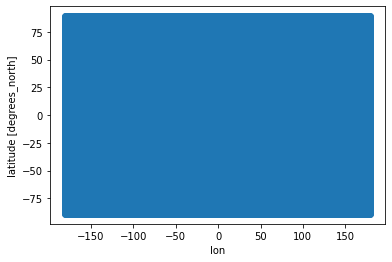

In [11]:
ds.plot.scatter(x = 'lon', y = 'lat') #, hue = 'Area_Name')

/home/smmrrr/miniconda3/envs/condaforge/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='lon', ylabel='lat'>

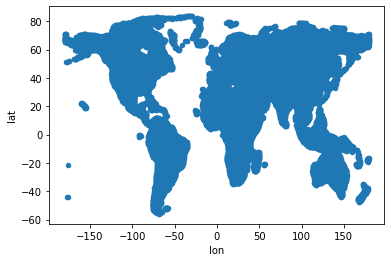

In [18]:
TEM.plot.scatter(x = 'lon', y = 'lat') #, hue = 'Area_Name')


In [19]:
##voi stands for variable of interest

voi_mean = ds.groupby(ds.time.dt.year).mean()
voi_min = ds.groupby(ds.time.dt.year).min()
voi_max = ds.groupby(ds.time.dt.year).max()
voi_sum = ds.groupby(ds.time.dt.year).sum()


In [20]:
voi_stats = xr.merge([voi_sum.rename({'var_of_interest':'sum'}), 
                      voi_max.rename({'var_of_interest':'max'}),
                    voi_mean.rename({'var_of_interest':'average'}),
                      voi_min.rename({'var_of_interest':'min'})
                     ])
voi_stats

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 320, year: 251)
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables:
    sum      (year, lat, lon) float32 53.12 53.38 53.61 ... 5.62 5.619 5.619
    max      (year, lat, lon) float32 6.715 6.741 6.857 ... 1.144 1.144 1.144
    average  (year, lat, lon) float32 4.426 4.449 4.468 ... 0.5109 0.5108 0.5108
    min      (year, lat, lon) float32 2.177 2.19 2.19 ... 0.08899 0.08901

In [21]:
monthly = xr.merge([ds.isel(time=(ds.time.dt.month == n)).rename(
            {'var_of_interest': calendar.month_abbr[n] }) for n in range(1, 13)])

monthly = monthly.groupby(ds.time.dt.year).min()

# tt.groupby(ds.time.dt.year).max() ##check they are the same



In [22]:
final = xr.merge([voi_stats, 
                      monthly
         ])
final

<xarray.Dataset>
Dimensions:  (lat: 160, lon: 320, year: 251)
Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 -180.0 -178.9 -177.8 -176.6 ... 176.6 177.8 178.9
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 53.12 53.38 53.61 ... 5.62 5.619 5.619
    max      (year, lat, lon) float32 6.715 6.741 6.857 ... 1.144 1.144 1.144
    average  (year, lat, lon) float32 4.426 4.449 4.468 ... 0.5109 0.5108 0.5108
    min      (year, lat, lon) float32 2.177 2.19 2.19 ... 0.08899 0.08901
    Jan      (year, lat, lon) float32 3.12 3.127 3.132 ... 0.6387 0.6386 0.6386
    Feb      (year, lat, lon) float32 3.175 3.194 3.21 ... 0.5301 0.53 0.5298
    ...       ...
    Jul      (year, lat, lon) float32 4.948 4.976 4.981 ... 0.5145 0.5143 0.514
    Aug      (year, lat, lon) float32 4.165 4.191 4.221 ... 0.4843 0.4843 0.4844
    Sep      (year, lat, lon) float32 6.715 6.741 6.857 ... 0.6683 0.6684 0.6686
    Oct      (year, lat, lon) float32 5.226 5.246 5.287 ... 0.122 0.1219 0.1218
    Nov      (year, lat, lon) float32 4.183 4.225 4.244 ... 1.144 1.144 1.144
    Dec      (year, lat, lon) float32 2.177 2.19 2.19 2.197 ... nan nan nan nan

In [13]:
#### DO THE NEAREST LON/LAT 

##old method
# TEM = TEM.set_index(['lon', 'lat'])
# TEM_xr = TEM.to_xarray()

#new method 
# TEM = TEM.reset_index()
TEM_xr = TEM.set_index(['lon', 'lat'])
TEM_xr = TEM_xr[['Area', 'Area_Name']].to_xarray()

TEM_xr = TEM_xr.assign_coords(lon=(TEM_xr.lon + 0.25))
TEM_xr = TEM_xr.assign_coords(lat=(TEM_xr.lat + 0.25))


ds_TEM = final.reindex_like(TEM_xr, method = 'nearest')
ds_TEM

NameError: name 'final' is not defined

In [64]:
int(ds_TEM.lat.min())
int(ds_TEM.lat.max())

83

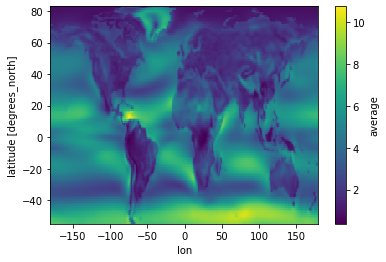

In [65]:
final.mean(dim = ['year']).average.sel( lat = slice(int(ds_TEM.lat.min()), int(ds_TEM.lat.max()))).plot()

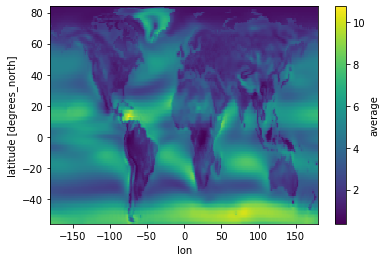

In [60]:
ds_TEM.mean(dim = ['year']).average.plot()

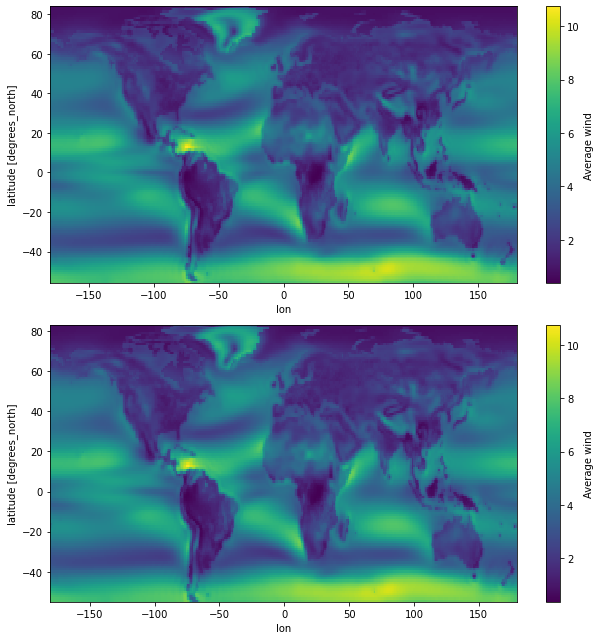

In [93]:
fig, axs = plt.subplots(nrows=2, figsize = (9, 9))
plot1 = ds_TEM.mean(dim = ['year']).average.plot(ax = axs[0], cbar_kwargs={'label': 'Average '+output_var})
plot2 = final.mean(dim = ['year']).average.sel( 
    lat = slice(int(ds_TEM.lat.min()), int(ds_TEM.lat.max()))).plot(ax = axs[1], cbar_kwargs={'label': 'Average '+output_var})
# cbar1 = plt.colorbar(plot1, ax=axs[0])
# plot2.cbar.set_label(label = 'Average '+output_var, size = 12)
plt.tight_layout()
plt.savefig(data_checks_folder+'plots/lat_lon_average_'+model+'_'+output_var+'.pdf')
plt.show()

In [52]:
# xr.merge([ds_TEM.mean(dim = ['lat', 'lon']),
orig_coords = final.mean(dim = ['lat', 'lon']).average.to_dataframe().reset_index()
tem_coords = ds_TEM.mean(dim = ['lat', 'lon']).average.to_dataframe().reset_index()
orig_coords = orig_coords.rename(columns={'average':'orig_average'})
tem_coords = tem_coords.rename(columns={'average':'tem_average'})
year_compare = orig_coords.merge(tem_coords)
year_compare['model'] = model
year_compare['output_var'] = output_var

In [54]:
year_compare.to_csv(data_checks_folder+'time_average_'+model+'_'+output_var+'.csv')


NameError: name 'data_checks_folder' is not defined

In [37]:
xr.merge([final, ds_TEM])

<xarray.Dataset>
Dimensions:  (lat: 369, lon: 864, year: 251)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 2.709e+03 nan nan nan ... nan nan nan nan
    max      (year, lat, lon) float32 254.3 nan nan nan nan ... nan nan nan nan
    average  (year, lat, lon) float32 225.8 nan nan nan nan ... nan nan nan nan
    min      (year, lat, lon) float32 205.8 nan nan nan nan ... nan nan nan nan
    Jan      (year, lat, lon) float32 252.7 nan nan nan nan ... nan nan nan nan
    Feb      (year, lat, lon) float32 238.7 nan nan nan nan ... nan nan nan nan
    ...       ...
    Jul      (year, lat, lon) float32 208.4 nan nan nan nan ... nan nan nan nan
    Aug      (year, lat, lon) float32 205.8 nan nan nan nan ... nan nan nan nan
    Sep      (year, lat, lon) float32 213.5 nan nan nan nan ... nan nan nan nan
    Oct      (year, lat, lon) float32 221.1 nan nan nan nan ... nan nan nan nan
    Nov      (year, lat, lon) float32 245.2 nan nan nan nan ... nan nan nan nan
    Dec      (year, lat, lon) float32 254.3 nan nan nan nan ... nan nan nan nan

In [38]:
final

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, year: 251)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 2.709e+03 2.709e+03 ... 3.248e+03
    max      (year, lat, lon) float32 254.3 254.3 254.3 ... 281.9 281.9 281.9
    average  (year, lat, lon) float32 225.8 225.8 225.8 ... 270.7 270.7 270.7
    min      (year, lat, lon) float32 205.8 205.8 205.8 ... 254.8 254.8 254.8
    Jan      (year, lat, lon) float32 252.7 252.7 252.7 ... 266.2 266.2 266.2
    Feb      (year, lat, lon) float32 238.7 238.7 238.7 ... 259.1 259.1 259.1
    ...       ...
    Jul      (year, lat, lon) float32 208.4 208.4 208.4 ... 279.6 279.6 279.6
    Aug      (year, lat, lon) float32 205.8 205.8 205.8 ... 281.9 281.9 281.9
    Sep      (year, lat, lon) float32 213.5 213.5 213.5 ... 279.8 279.8 279.8
    Oct      (year, lat, lon) float32 221.1 221.1 221.1 ... 275.4 275.4 275.4
    Nov      (year, lat, lon) float32 245.2 245.2 245.2 ... 272.4 272.4 272.4
    Dec      (year, lat, lon) float32 254.3 254.3 254.3 ... 270.1 270.1 270.1

In [39]:
ds_TEM

<xarray.Dataset>
Dimensions:  (lon: 720, lat: 280, year: 251)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables: (12/16)
    sum      (year, lat, lon) float32 3.333e+03 3.333e+03 ... 3.247e+03
    max      (year, lat, lon) float32 282.3 282.3 282.4 ... 279.1 279.1 279.1
    average  (year, lat, lon) float32 277.8 277.8 277.7 ... 270.6 270.6 270.6
    min      (year, lat, lon) float32 274.6 274.6 274.6 ... 256.1 256.1 256.1
    Jan      (year, lat, lon) float32 281.4 281.4 281.3 ... 268.2 268.2 268.2
    Feb      (year, lat, lon) float32 282.3 282.3 282.4 ... 260.4 260.4 260.4
    ...       ...
    Jul      (year, lat, lon) float32 275.5 275.5 275.4 ... 276.0 276.0 276.0
    Aug      (year, lat, lon) float32 274.9 274.9 274.9 ... 279.1 279.1 279.1
    Sep      (year, lat, lon) float32 276.0 276.0 275.8 ... 278.2 278.2 278.2
    Oct      (year, lat, lon) float32 277.1 277.1 277.0 ... 275.4 275.4 275.4
    Nov      (year, lat, lon) float32 277.6 277.6 277.4 ... 273.3 273.3 273.3
    Dec      (year, lat, lon) float32 278.7 278.7 278.6 ... 271.6 271.6 271.6

In [ ]:


# TEM_xr.sel(lon = -180, lat = -16.5)
# ds_TEM.sel(lon = -180, year = 1960)

In [90]:
#verify that the nearest lon/lat is working 
# final.sel(lat = -55.25, lon = -180.25, year = 1960).to_pandas()
# ds_TEM.sel(lat = -55.5, lon = -180, year = 1960).to_pandas()



In [11]:
##take a look at bounds of lat/lon in final vs ds_TEM
print(final['lon'])
# print(ds_TEM['lon'])

print(final['lat'])
# print(ds_TEM['lat']) ## !!!is the -0.25 right on the edge cases of -90 and 90?!!!

<xarray.DataArray 'lon' (lon: 128)>
array([-180.    , -177.1875, -174.375 , -171.5625, -168.75  , -165.9375,
       -163.125 , -160.3125, -157.5   , -154.6875, -151.875 , -149.0625,
       -146.25  , -143.4375, -140.625 , -137.8125, -135.    , -132.1875,
       -129.375 , -126.5625, -123.75  , -120.9375, -118.125 , -115.3125,
       -112.5   , -109.6875, -106.875 , -104.0625, -101.25  ,  -98.4375,
        -95.625 ,  -92.8125,  -90.    ,  -87.1875,  -84.375 ,  -81.5625,
        -78.75  ,  -75.9375,  -73.125 ,  -70.3125,  -67.5   ,  -64.6875,
        -61.875 ,  -59.0625,  -56.25  ,  -53.4375,  -50.625 ,  -47.8125,
        -45.    ,  -42.1875,  -39.375 ,  -36.5625,  -33.75  ,  -30.9375,
        -28.125 ,  -25.3125,  -22.5   ,  -19.6875,  -16.875 ,  -14.0625,
        -11.25  ,   -8.4375,   -5.625 ,   -2.8125,    0.    ,    2.8125,
          5.625 ,    8.4375,   11.25  ,   14.0625,   16.875 ,   19.6875,
         22.5   ,   25.3125,   28.125 ,   30.9375,   33.75  ,   36.5625,
         39.375

In [12]:
## TEM is higher resolution than the climate data
# 3012*720*280 #months x lon x lat 
# 3012*192*145 #months x lon x lat 
#83854080 #number of rows in climate dataset
#607219200 #number of rows in matched dataset 
print(ds_TEM.Jan.count())
print(final.Jan.count())


<xarray.DataArray 'Jan' ()>
array(90921600)
<xarray.DataArray 'Jan' ()>
array(3694592)


In [ ]:
#### FORMAT USING OLD SCRIPT 

#get list of variable names
#do the correct transformation by variable name 

In [290]:
# list(range(10, 310, 10))


In [13]:

for i in range(10, 310, 10):

    rep_decade = ds_TEM.sel(year = slice(1850, 1859))
    rep_decade['year'] = rep_decade.year - i

    if i == 10:
        rep_past = rep_decade
    else:
        rep_past = rep_past.combine_first(rep_decade)

    print(i)
    
    
rep_past

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300


<xarray.Dataset>
Dimensions:  (year: 300, lat: 280, lon: 720)
Coordinates:
  * year     (year) int64 1550 1551 1552 1553 1554 ... 1845 1846 1847 1848 1849
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.75 -55.25 -54.75 -54.25 ... 82.75 83.25 83.75
Data variables: (12/16)
    sum      (year, lat, lon) float32 105.7 105.7 105.7 ... 22.39 22.39 22.39
    max      (year, lat, lon) float32 11.13 11.13 11.13 ... 3.267 3.267 3.267
    average  (year, lat, lon) float32 8.812 8.812 8.812 ... 1.866 1.866 1.866
    min      (year, lat, lon) float32 4.767 4.767 4.767 ... 0.4684 0.4684 0.4684
    Jan      (year, lat, lon) float32 7.832 7.832 7.832 ... 0.4684 0.4684 0.4684
    Feb      (year, lat, lon) float32 7.251 7.251 7.251 ... 2.399 2.399 2.399
    ...       ...
    Jul      (year, lat, lon) float32 10.86 10.86 10.86 ... 2.463 2.463 2.463
    Aug      (year, lat, lon) float32 11.13 11.13 11.13 ... 1.488 1.488 1.488
    Sep      (year, lat, lon) float32 11.11 11.11 11.11 ... 0.886 0.886 0.886
    Oct      (year, lat, lon) float32 9.366 9.366 9.366 ... 0.7668 0.7668 0.7668
    Nov      (year, lat, lon) float32 9.308 9.308 9.308 ... 2.282 2.282 2.282
    Dec      (year, lat, lon) float32 4.767 4.767 4.767 ... 3.267 3.267 3.267

In [14]:
ds_TEM = ds_TEM.combine_first(rep_past)

print(ds_TEM.year.min())
print(ds_TEM.year.max())


<xarray.DataArray 'year' ()>
array(1550)
<xarray.DataArray 'year' ()>
array(2300)


In [15]:
ds_TEM = xr.merge([ds_TEM, TEM_xr])

In [16]:
ds_TEM2 = ds_TEM.to_dataframe()

In [21]:
ds_TEM2 = ds_TEM2.dropna()

In [22]:
ds_TEM2 = ds_TEM2.reset_index()

In [23]:
print(ds_TEM2['lat'].nunique())
print(ds_TEM2['lon'].nunique())
print(ds_TEM2['year'].nunique())

280
720
551


In [24]:
# 280*720*551
cvar = 'temp'

In [25]:
ds_TEM2['var'] = ' ' + cvar + ' '


ds_TEM2 = ds_TEM2[["lon", 'lat','var' ,'Area', 'year', 'sum', 'max', 'average'
         , 'min', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'
         , 'Nov', 'Dec', 'Area_Name']]



In [55]:

ds_TEM2.to_csv(cleaned_data_folder+model+'_'+scenario+'_'+output_var+'.csv',index = False)


NameError: name 'ds_TEM2' is not defined

In [26]:
# ds

## get coordinates 
systime = time.ctime(time.time())
print(f"\nStart time: {systime}")


Start time: Wed Jul 27 12:23:19 2022


In [ ]:
##### old program that is too slow replicated from R program TEM_historical_kelley_chu.R


i = 1
year = 1888


lon = round(TEM.loc[i, 'lon'], 4)
lat = round(TEM.loc[i, 'lat'], 4)
    
if (lat < 0 or lon < 0):  ##is this what we want?? lat is 
                    #always negative so this isnt doing anything
    lat = lat + 90
    lon = lon + 180
            
lat = lat + 0.25
lon = lon + 0.25
        
if year < 1861:
    year_l = str(year)
    year_l = year_l[-1]
    year_l = 1860 + int(year_l)
else: 
    year_l = year
    
t_index = np.min(np.where(ds['time'].dt.year == year_l))
t_index = t_index +  [i for i in range(12)]
lon_index = np.argmin(np.array(np.abs(ds['lon'] - lon)))
lat_index = np.argmin(np.array(np.abs(ds['lat'] - lat)))
ds_subset = ds.isel(time=t_index, lat = [lat_index], lon = [lon_index])
ds_subset = ds_subset.to_dataframe()
ds_subset = ds_subset.reset_index()
ds_subset['sum_val'] = ds_subset['tas'].sum()
ds_subset['min_val'] = ds_subset['tas'].min()
ds_subset['max_val'] = ds_subset['tas'].max()
ds_subset['avg_val'] = ds_subset['tas'].mean()
ds_subset['var'] = TEM.loc[i, 'Variable']
ds_subset['area'] = TEM.loc[i, 'Area']
ds_subset['year'] = year
ds_subset['lat_TEM'] = lat
ds_subset['lon_TEM'] = lon
